# Loading and Plotting Data

[Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI.
 
Initially, I'm only using two features from the data set: alcohol and ash.  The labels are supplied as an array of data with values from `1` to `3`, but at first, I only want a simple regression problem with a `yes` or `no` answer.  

To do this, I first filter the data set, reducing it to only include wines with labels `1` or `2`.  Then, I use the scikit-learn `label_binarize` function, which takes an $m$-length list with $n$ possible values (two, in this case), and converts it to an $m \times n$ matrix, where each column represents one label with a value of `1`, and all others with a value of `0`.  I choose the first column, though the second would be equally valid here, just with the labels reversed.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('../data/data.txt')
data.head()

,class,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color,hue,od,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
data['class'].drop_duplicates()

0      1
59     2
130    3
Name: class, dtype: int64

In [16]:
reduced = data[data['class'].isin([1, 2])]
X = reduced[['alcohol', 'ash']].to_numpy()
print(X[:5])

[[14.23  2.43]
 [13.2   2.14]
 [13.16  2.67]
 [14.37  2.5 ]
 [13.24  2.87]]


In [17]:
y = label_binarize(reduced['class'].values, classes=[1, 2])[:,0]
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, classes=list(set(example)))
print('binarized:\n', example)
print('1s vs all:', example[:,0])

original: [1 2 2 1 3 2 1 1 3 3]
binarized:
 [[1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]
1s vs all: [1 0 0 1 0 0 1 1 0 0]


I also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 25%) to sample randomly from the data set and partition away for testing.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


Because I'm going to be drawing a lot of data plots, I define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

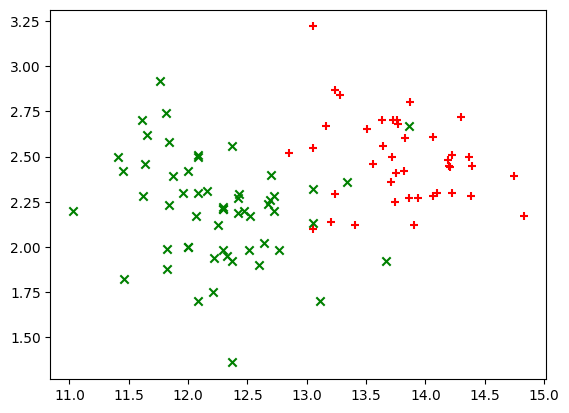

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

There's a fairly obvious area near the center of the plot where a line could divide the two colors of points with a small amount of error.

# Simple Logistic Regression

To implement logistic regression, I need a hypothesis function $h_\theta(x)$, a cost function $J(\theta)$, and a gradient function that computes the partial derivatives of $J(\theta)$.

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between 0 and 1, and produces a value that can be interpreted as a probability.  This value can also be a yes / no answer with a cross-over, or decision boundary, at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [4]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the matrix operations work correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below, and with TensorFlow.  The indexing syntax can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing a gradient descent, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

In [5]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [ 116.44453348   -8.22298266   -3.26236478]


# Decision Boundaries and Evaluation


I can evaluate the results of the optimization visually and statistically, but I also need one more function: `predict`, which takes an array of examples `X` and learned parameter values `theta` as inputs and returns the predicted label for each.  Here too, 1s must be prepended to the inputs, and I return an integer value representing whether the result of the `sigmoid` hypothesis function is equal to or greater than 0.5.

To test the results of those predictions, Scikit-learn provides three functions to calculate [accuracy, precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).  The test data from earlier is used here, so the results represent the performance of the classifier on unseen data.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.848484848485
precision: 0.868421052632
recall: 0.868421052632


It's much more interesting to review the results visually, at least while the number of features is limited to two.  To do this, I need to plot the input points again, then overlay the decision boundary on top.  I tried several approaches for this in Matplotlib, and found that an unfilled countour plot gave me the best results.  This can also be done by manually calculating the function to plot, or using a filled contour plot that shades over the actual areas, but doing the math by hand is tedious, and the colormaps for filled contour plots leave a lot to be desired visually.

Below, I define a function `plot_boundary` that takes $n \times 2$ matrix of feature values $(x_0, x_1)$ and a prediction function, then builds a mesh grid of $(x, y)$ points corresponding to possible $(x_0, x_1)$ values within the input range.  After running the prediction function on all of them, the result is an $(x, y, z)$ point in space.  Because the result isn't continuous and flips directly from 0 to 1, there's only one contour that can be drawn on the plot: the decision boundary.

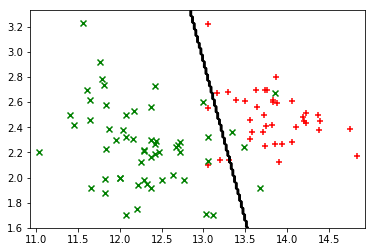

In [7]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

# Multinomial Logistic Regression

With the basics working, the next step is something more interesting: a similar set of two features from the data set (this time alcohol and flavanoids), but with all three labels instead of two.  The only differences below in loading the data are that I no longer filter out rows with the third label, that I use the full output from `label_binarize`, resulting in an $m \times 3$ array for `y`.

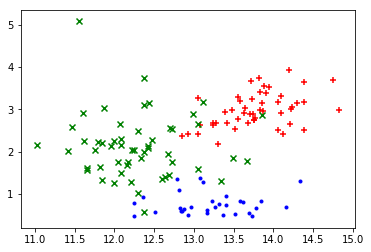

In [8]:
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = label_binarize(y_train, [1, 2, 3])

plot_points(X_train, y_train.argmax(axis=1))

The plotted data points again suggest some obvious linear boundaries between the wines.

It turns out that solving this as three one-vs-all problems is trivial, and re-uses all the code I just wrote.  Instead of one array of `theta` values I train three, one per problem, and then define a new `predict_multi` function that computes the three sigmoids for each example using each array of `theta` parameters.  This time, rather than return `1` or `0` based on whether the value is above or below 0.5, I return the `argmax` of each resulting row, the index of the largest value.

accuracy: 0.933333333333
precision: 0.945304437564
recall: 0.928540305011


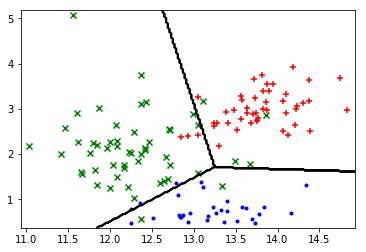

In [9]:
def predict_multi(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(x, thetas))

Looking at the plot above, it seems like the boundaries could be much more accurate if they didn't have to be straight lines.  To allow for this, I define a function `transform` to add some polynomial features, converting each input example of $(x_0, x_1)$ to $(x_0, x_1, x_2, x_3, x_4)$, where $x_2 = x_0^2$, $x_3 = x_1^2$ and $x_4 = x_0x_1$.

accuracy: 0.977777777778
precision: 0.981481481481
recall: 0.981481481481


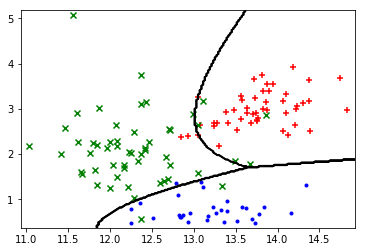

In [10]:
def transform_x(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def transform(X):
    return np.apply_along_axis(transform_x, 1, X)

X_train = transform(X_train)
X_test = transform(X_test)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(transform(x), thetas))

# Regularization

Next, I want to include all the features from the data set.  To do this, instead of specifying what columns I want to include, I use `drop` to include everything except the `class` column.

Because I'm now significantly increasing the number of features, I apply [regularization](https://www.quora.com/What-is-regularization-in-machine-learning) as part of new cost and gradient functions.  Regularization prevents overfitting, a situation where a large number of features allows the classifier to fit the training set *too* exactly, meaning that it fails to generalize well and perform accurately on data it hasn't yet seen.

To avoid this problem, I add an additional term to the cost function and its gradient, representing the aggregated weights of each $\theta$ parameter.  Adding this term effectively increases the cost, meaning that the overall impact of feature weights is muted, and the fit to the training set is softened.  Note that for each of the new cost and gradient functions, the summation for regularization starts at $j = 1$, since the constant bia parameter $\theta_0$ is typically not regularized:

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}[y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2 \\
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i + \frac{\lambda}{m}\theta_j
$$

Below, I define the new cost and gradient functions, as well as a new function to train the classifier, given the addition of a new parameter `l`, for $\lambda$.  This parameter can be adjusted to change the effect of regularization; here I'm just using `1.0`.  In each case, I ensure that $\theta_0$ isn't regularized by creating a temporary `theta_reg`, starting with a zero followed by elements one and onward from `theta`.

In [17]:
X = data.drop('class', 1).as_matrix()
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = label_binarize(y_train, [1, 2, 3])

def cost_reg(theta, X, y, lambda_):
    theta_reg = np.array((0, *theta[1:]))[:,None]
    reg = lambda_ * np.square(theta_reg).sum() / (2 * len(X))
    
    return cost(theta, X, y) + reg

def gradient_reg(theta, X, y, lambda_):
    theta_reg = np.array((0, *theta[1:]))[:,None]
    reg = lambda_ * theta_reg / len(X)
    
    return gradient(theta, X, y) + reg

def train_reg(X, y, lambda_):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost_reg, x0=theta, fprime=gradient_reg, args=(X, y, lambda_))
    
    return result[0]

thetas = [train_reg(X_train, y_train[:,i], 1.0) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.977777777778
precision: 0.981481481481
recall: 0.97619047619


# Logistic Regression with TensorFlow

In this last section, I implement logistic regression using TensorFlow and test the model using the same data set.  TensorFlow allows for a significantly more compact and higher-level representation of the problem as a computational graph, resulting in less code and faster development of models.

One item definitely worth calling out is the use of the [`AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) instead of the [`GradientDescentOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) from the previous post.  Although the latter can still be used here, I found it a poor fit for two reasons:  it is *very* sensitive to learning rate and lambda parameters, and it converges extremely slowly.  Correct convergence required a very low learning rate (around 0.001 at most), and could still be seen decreasing at over 300,000 iterations, with a curve that appeared linear after the first thousand.  Poor tuning resulted in the optimizer spinning out of control and emitting `nan` values for all the parameters.

Using a different optimizer helped tremendously, especially one that is [adaptive](https://stackoverflow.com/questions/33919948/how-to-set-adaptive-learning-rate-for-gradientdescentoptimizer).  It converges significantly faster and requires much less hand-holding to do so.  Even then, these graphs take typically 25x the time to converge properly compared to the manual implementation above, and I'm not sure why this is the case.  Since Tensorflow does the calculus itself to find the gradient, it could be that this is the result of some issue or lack of optimization.  On the other hand, given that the platform is designed to distribute computations and scale to significantly larger data sets, this could be some overhead that is quite reasonable in those scenarios but is felt heavily in a small demonstration with a tiny number of examples.

I also adjusted all placeholders and variables to `tf.float64`, to avoid any issues with numerical precision.  After this and the adaptive optimizer, the results improved dramatically.

Because I want to build a few different graphs, I define a function that builds one given a few parameters: the number of features, the number of labels, and a lambda value for regularization.  This function `tf_create` builds a graph, and returns two functions itself: one to train the algorithm by running the optimizer, and another to predict labels for new values.  To compute the loss for regularization, I use the built-in `tf.nn.l2_loss` function, which is equivalent to the regularization loss I computed manually before.

In [12]:
import tensorflow as tf

def tf_create(n_features, n_labels, lambda_):
    
    examples = tf.placeholder(tf.float64, [None, n_features])
    labels = tf.placeholder(tf.float64, [None, n_labels])
    weights = tf.Variable(tf.zeros([n_features, n_labels], dtype=tf.float64))
    bias = tf.Variable(tf.zeros([n_labels], dtype=tf.float64))
    
    hyp = tf.sigmoid(tf.matmul(examples, weights) + bias)
    loss = tf.reduce_mean(-labels * tf.log(hyp) - (1 - labels) * tf.log(1 - hyp))
    reg = lambda_ * tf.nn.l2_loss(weights)
    cost = loss + reg
    
    train = tf.train.AdamOptimizer().minimize(cost)
    predict = tf.argmax(hyp, axis=1)
    
    def train_(sess, X, y, iterations):
        for i in range(iterations):
            sess.run(train, feed_dict={examples: X, labels: y})
            
    def predict_(sess, X):
        return sess.run(predict, feed_dict={examples: X})
    
    return train_, predict_

First, I evaluate the model against the 2-feature, 3-label example from above.

accuracy: 0.955555555556
precision: 0.95584045584
recall: 0.95584045584


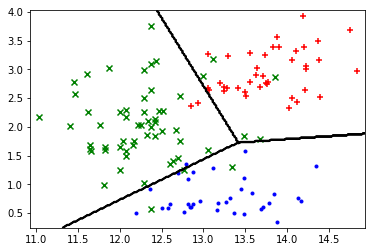

In [20]:
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
y = label_binarize(data['class'], [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with tf.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.0)
    sess.run(tf.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_boundary(X_train, lambda x: predict(sess, x))
    plot_points(X_train, y_train.argmax(axis=1))

Next, I use the `transform` function to apply additional polynomial features to the dataset, allowing for a non-linear decision boundary.

accuracy: 0.977777777778
precision: 0.97619047619
recall: 0.980392156863


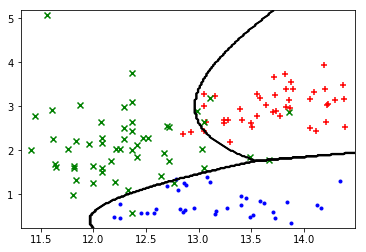

In [24]:
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
X = transform(X)
y = label_binarize(data['class'], [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with tf.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.0)
    sess.run(tf.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_boundary(X_train, lambda x: predict(sess, transform(x)))
    plot_points(X_train, y_train.argmax(axis=1))

Finally, I include all the features from the data set, all the labels, and apply a small amount of regularization.

In [26]:
X = data.drop('class', 1).as_matrix()
y = label_binarize(data['class'], [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with tf.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.1)
    sess.run(tf.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.955555555556
precision: 0.961873638344
recall: 0.951178451178


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [49]:
iris = load_iris()
X = iris.data
y = iris.target

std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

In [61]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [86]:
x_new = X[[1, 60, 120]]
y_new = y[[1, 60, 120]]
log_reg.predict(x_new)

array([0, 1, 2])

In [63]:
log_reg.score(X, y)

0.9733333333333334

In [64]:
log_reg.classes_

array([0, 1, 2])

In [65]:
log_reg.coef_

array([[-1.07659238,  1.15977648, -1.92814138, -1.81227307],
       [ 0.5899243 , -0.36263595, -0.36461312, -0.82700241],
       [ 0.48666809, -0.79714052,  2.2927545 ,  2.63927548]])

In [66]:
log_reg.intercept_

array([-0.20463897,  2.07455834, -1.86991938])

In [72]:
logits = x_new @ log_reg.coef_.T + log_reg.intercept_
logits

array([[ 5.84094813,  3.02466519, -8.86561331],
       [-1.16909841,  2.62484311, -1.4557447 ],
       [-5.95608469,  1.11012666,  4.84595804]])

In [75]:
def softmax(arr):
    return np.exp(arr) / np.exp(arr).sum(axis=-1, keepdims=True)

In [105]:
softmax(logits)

array([[9.43549042e-01, 5.64505708e-02, 3.87066866e-07],
       [2.16534771e-02, 9.62089585e-01, 1.62569377e-02],
       [1.98831902e-05, 2.32971428e-02, 9.76682974e-01]])

In [106]:
log_reg.predict_proba(x_new)

array([[9.43549042e-01, 5.64505708e-02, 3.87066866e-07],
       [2.16534771e-02, 9.62089585e-01, 1.62569377e-02],
       [1.98831902e-05, 2.32971428e-02, 9.76682974e-01]])

In [79]:
softmax(logits).argmax(1)

array([0, 1, 2])

In [83]:
yy = y[(y == 0)+(y == 1)]
XX = X[(y == 0)+(y == 1)]

In [84]:
log_reg2 = LogisticRegression()
log_reg2.fit(XX, yy)

LogisticRegression()

In [85]:
x_new

array([[-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.02184904, -2.43394714, -0.14664056, -0.26238682],
       [ 1.2803405 ,  0.32841405,  1.10378283,  1.44883158]])

In [87]:
y_new

array([0, 1, 2])

In [88]:
log_reg2.predict(x_new)

array([0, 1, 1])

In [91]:
log_reg2.coef_

array([[ 1.04403159, -1.23411798,  1.74109341,  1.5911881 ]])

In [97]:
logits2 = x_new @ log_reg2.coef_.T + log_reg2.intercept_
logits2

array([[-3.05573478],
       [ 3.66542517],
       [ 7.55987843]])

In [96]:
def sigmoid(arr):
    return 1 / (1 + np.exp(-arr))

In [100]:
probs = sigmoid(logits2)
probs

array([[0.04497053],
       [0.97504538],
       [0.99947933]])

In [99]:
def predict(probs):
    return np.where(probs >= 0.5, 1, 0)

In [101]:
predict(probs)

array([[0],
       [1],
       [1]])

In [103]:
log_reg2.predict_proba(x_new)

array([[9.55029469e-01, 4.49705313e-02],
       [2.49546168e-02, 9.75045383e-01],
       [5.20667335e-04, 9.99479333e-01]])

In [117]:
from sklearn.multiclass import OneVsOneClassifier

log_reg3 = OneVsOneClassifier(LogisticRegression())
log_reg3.fit(X, y)

OneVsOneClassifier(estimator=LogisticRegression())